In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Jiang

In [15]:
rlz = pd.read_pickle('data/RLz_jan9b_reruns.pkl')
# nef = pd.read_pickle('data/NEF_RL_jan9b_reruns.pkl')
human = pd.read_pickle("data/jiang.pkl")
neurons = [50,100,200,300,400,500]

columns = ['type', 'neurons', 'sid', 'trial', 'stage', 'neighbors', 'is_greedy', 'noise_driven']
dfs = []
sids = human['sid'].unique()
for sid in sids:
    print(sid)
    trials = human.query("sid==@sid")['trial'].unique()
    for n in neurons:
        nef = pd.read_pickle(f'data/NEF_RL_jiang_{n}neurons_dynamics.pkl')
        for trial in trials:
            neighbors = len(human.query("sid==@sid & trial==@trial & stage==1")['who'].unique())
            stages = human.query("sid==@sid & trial==@trial")['stage'].unique()
            for stage in stages:
                action_rl = rlz.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                action_human = human.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                action_nef = nef.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                expectation_rl = rlz.query("sid==@sid & trial==@trial & stage==@stage")['expectation'].to_numpy()[-1]
                expectation_nef = nef.query("sid==@sid & trial==@trial & stage==@stage")['expectation'].to_numpy()[-1]
                sign_rl = 1 if expectation_rl > 0 else -1
                sign_nef = 1 if expectation_nef > 0 else -1
                is_greedy = True if action_human==sign_rl else False
                noise_driven = True if sign_nef!=sign_rl else False
                dfs.append(pd.DataFrame([["NEF_RL", n, sid, trial, stage, neighbors, is_greedy, noise_driven]], columns=columns))
noise_driven_data = pd.concat(dfs, ignore_index=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
134
135
136
137
138
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224


In [16]:
noise_driven_data.to_pickle("data/noise_driven_data.pkl")
# noise_driven_data = pd.read_pickle("data/noise_driven_data.pkl")

In [17]:
dfs = []
columns = ['type', 'neurons', 'sid', 'is_greedy', 'noise_driven', "sample size"]
for sid in sids:
    for neurons in noise_driven_data['neurons'].unique():
        greedy_subdata = noise_driven_data.query("sid==@sid & neurons==@neurons & is_greedy==True")
        nongreedy_subdata = noise_driven_data.query("sid==@sid & neurons==@neurons & is_greedy==False")
        greedy_noisy = greedy_subdata.query("noise_driven==True").size
        greedy_choicy = greedy_subdata.query("noise_driven==False").size
        greedy_sample_size = greedy_noisy + greedy_choicy
        greedy_fraction = greedy_noisy / greedy_sample_size
        nongreedy_noisy = nongreedy_subdata.query("noise_driven==True").size
        nongreedy_choicy = nongreedy_subdata.query("noise_driven==False").size
        nongreedy_sample_size = nongreedy_noisy + nongreedy_choicy
        nongreedy_fraction = nongreedy_noisy / nongreedy_sample_size
        dfs.append(pd.DataFrame([["NEF_RL", neurons, sid, True, greedy_fraction, greedy_sample_size]], columns=columns))
        dfs.append(pd.DataFrame([["NEF_RL", neurons, sid, False, nongreedy_fraction, nongreedy_sample_size]], columns=columns))
noise_data_fraction = pd.concat(dfs, ignore_index=True)

In [18]:
noise_data_fraction.to_pickle("data/noisy_data_fraction.pkl")
# noise_data_fraction = pd.read_pickle("data/noisy_data_fraction.pkl")

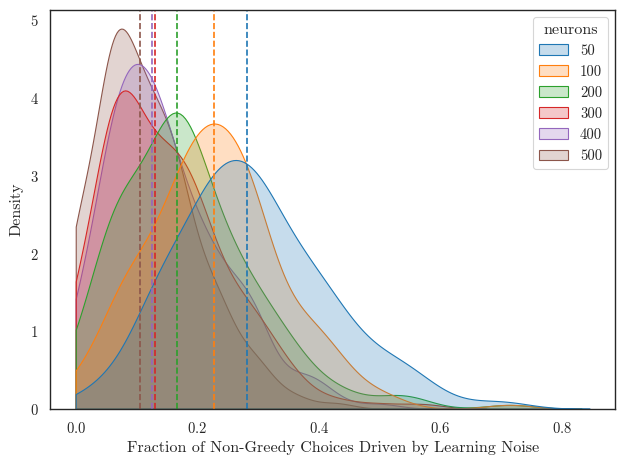

In [20]:
fig, ax = plt.subplots()
sns.kdeplot(noise_data_fraction.query("is_greedy==False"), x='noise_driven', hue='neurons',
            palette=palette[:6], common_norm=False, fill=True, clip=[0,1])
for n, neurons in enumerate(noise_data_fraction['neurons'].unique()):
    median = noise_data_fraction.query("is_greedy==False & neurons==@neurons")['noise_driven'].median()
    ax.axvline(median, color=palette[n], ls="--")
ax.set(xlabel="Fraction of Non-Greedy Choices Driven by Learning Noise")
plt.tight_layout()
fig.savefig("plots/NEF_RL_learning_noise_vs_neurons_jiang.jpg", dpi=600)